# How Hyperspectral3DRCNet model works

## Table of Contents

* [Hyperspectral imaging](#Hyperspectral-imaging)
* [Prepare hyperspectral training data](#Prepare-hyperspectral-training-data)
* [Architecture](#Architecture)
  * [Sample extraction](#Sample-extraction)
  * [Multi-stage feature extraction](#Multi-stage-feature-extraction)
  * [Classifier](#classifier)
  * [3D-RCBlock](#3D-RCBlock)
* [Implementation in arcgis.learn](#Implementation-in-arcgis.learn) 
* [References](#References)

## Hyperspectral imaging

Hyperspectral imaging is an advanced technique that merges spectroscopy with imaging, allowing for the collection of rich spectral information at every pixel in an image. Unlike traditional multispectral imagery that capture fewer bands or wavelengths i.e. blue, green, red, near infrared, shortwave infrared etc, hyperspectral systems record hundreds of narrow, contiguous wavelength bands across a wide range of the electromagnetic spectrum.

This technology enables precise identification and analysis of materials based on their unique spectral signatures — the specific way each substance reflects or absorbs light. Hyperspectral imaging, as one of the most powerful forms of spectral imaging, enables new possibilities in environmental monitoring, agriculture, and many other applications where understanding material composition is essential.

<p style="text-align: center;">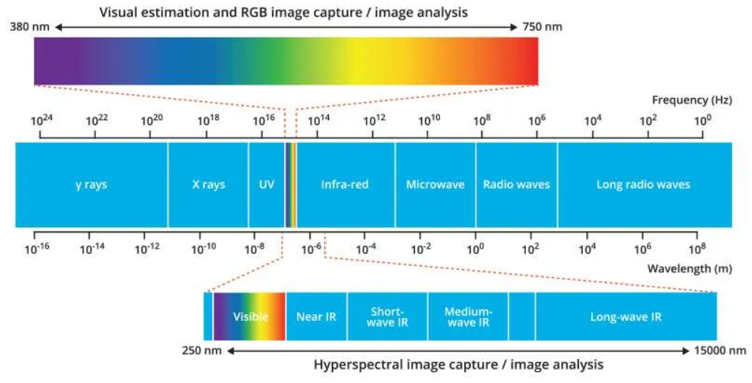</p>

<center> Figure 1. Hyperspectral imaging capturing wavelengths. [3] </center>

In this guide, we will focus on `Hyperspectral3DRCNet`, a convolutional and transformer based deep learning model originally developed by [Haizhao et al](https://arxiv.org/pdf/2408.13728).

### Hyperspectral Data cube

A hyperspectral data cube is a three-dimensional dataset with two spatial dimensions (X and Y) and one spectral dimension λ (lambda). In case of remote sensing, the hyperspectral data cube has a three-dimensional structure: two dimensions for location (like latitude and longitude on Earth) and one dimension for the electromagnetic spectrum. It is the result of hyperspectral imaging, where each pixel contains a full spectrum of light intensity across many narrow, contiguous wavelengths, allowing for detailed material analysis.  

<p style="text-align: center;">
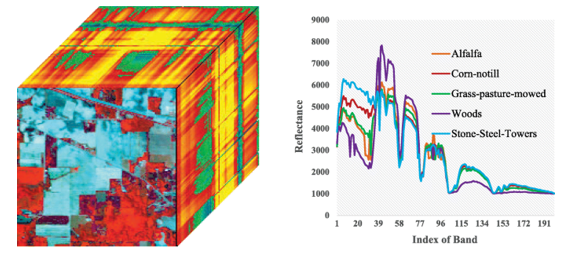
</p>

<center> Figure 2. Hyperspectral data cube and cross-sectional spectral signature. [2] </center>

## Prepare hyperspectral training data

The [Export Training Data for Deep Learning](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) tool is used to export training data for the model. The input is a hyperspectral imagery preferably filtered using PCA (Principal Component Analysis) for dimensionality reduction and to reduce correlation. 

Training label raster is a thematic raster with all pixels labelled into certain class. Pixels are labelled into different classes, based on the available information. Thematic raster consisting of different land use/land cover classes are shown in the figure below.

<p style="text-align: center;">
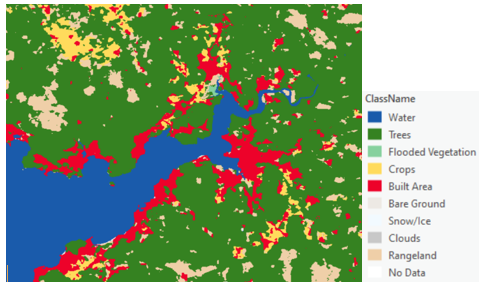
</p>

<center> Figure 3. Sample thematic raster overlayed on hyperspectral imagery  </center> 

## Architecture

`Hyperspectral3DRCNet` is a hybrid convolution–attention framework for hyperspectral image (HSI) classification. It integrates 3D convolutional blocks and the proposed 3D Relational Convolutional Block (3D-RCBlock) to efficiently extract spectral–spatial features. The network operates in three stages: sample extraction, multi-stage feature extraction, and classification.

<p style="text-align: center;">
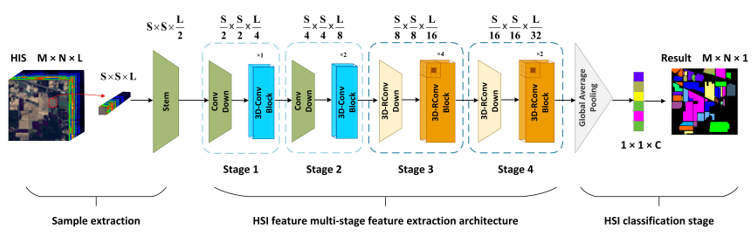
</p>

<center> Figure 4. 3D-RCNet framework  </center> 

### Sample extraction

A cube of size S × S × L (spatial window × spectral bands) centred on each target pixel is extracted. The cube passes through a Stem layer that compresses spectral dimensions and captures initial features.

### Multi-stage feature extraction

Stages 1–2 as shown in figure 4 use 3D convolutional blocks for low- and mid-level spectral–spatial feature learning. Stages 3–4 employ 3D-RCBlocks, which integrate attention within local 3 × 3 × 3 neighbourhoods to model adaptive inter-band relationships while maintaining convolutional efficiency. Progressive down sampling [2, 4, 8, 16] enhances abstraction across layers.

### Classifier

Global Average Pooling (GAP) aggregates the final 3D feature maps into a fixed length embedding, followed by fully connected layers to produce class logits.

### 3D-RCBlock

The 3D-RCBlock combines the locality of convolution with the adaptability of self-attention.
Within each 3 × 3 × 3 window, the centre pixel acts as a query, and surrounding pixels as keys and values. Dynamic weights are computed via exponential similarity, generating adaptive kernels that capture relational context with far lower computational cost than full self-attention.
This design retains translation invariance, reduces multiply-accumulate operations, and enables deeper, more discriminative feature extraction for HSI data.

## Implementation in `arcgis.learn`

`Input Raster` - Hyperspectral imagery in imagery format (tiff, mrf).

`Export` - use the input raster to export the raster chips in Classified Tiles metadata format using [Export Training Data for Deep Learning](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) tool available in ArcGIS Pro. The resulting path from from export tool is provided to prepare_data function in arcgis.learn to create a databunch. The sample extraction phase of the framework runs during prepare_data.

`data = prepare_data(path=r"path/to/exported/data", window_size)`
                    
where,

- `window_size` – Optional. default set to 27. pixel width and height of each square patch extracted around a labeled pixel for training. 

By default, initialization of the `Hyperspectral3DRCNet` object as shown below:

`model = arcgis.learn.Hyperspectral3DRCNet(data)`

model parameters that can be passed using keyword arguments:
- `depths` - Optional int list. Number of blocks at each stage. Default set to [1, 2, 4, 2]
- `dims` - Optional int list. Feature dimension at each stage. Default set to [32, 64, 128, 256]
- `drop_path_rate` - Optional float. Stochastic depth rate. Default set to 0.05.
- `layer_scale_init_value` - Optional float. Init value for Layer Scale. Default set to 1e-6.
- `head_init_scale` - Optional float. Init scaling value for classifier weights and biases. Default set to 1.

Default values for optimal performance are set for model's hyperparameters.
Here, data is the object returned from prepare_data function.
For more information about the API, please go through the
 [API reference](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html).

## References

- [1] Jing, Haizhao, Liuwei Wan, Xizhe Xue, Haokui Zhang, and Ying Li. "3d-rcnet: Learning from transformer to build a 3d relational convnet for hyperspectral image classification." arXiv preprint arXiv:2408.13728 (2024).
- [2] Cao, Chunhong, Liu Deng, Wei Duan, Fen Xiao, WanChun Yang, and Kai Hu. "Hyperspectral image classification via compact-dictionary-based sparse representation." Multimedia Tools and Applications 78, no. 11 (2019): 15011-15031.
- [3] https://www.specim.com